In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from numpy.testing import assert_array_equal
from tqdm.notebook import tqdm

In [2]:
from microagg1d.main import _simple_dynamic_program,_simple_dynamic_program2,  compute_cluster_cost_sorted
from microagg1d.wilber import wilber, _galil_park
from microagg1d.wilber2 import _wilber2, _galil_park2, _staggered2

In [3]:
from functools import partial

In [4]:
def execute(ns, n_samples, methods, ks=[2, 5, 10, 20, 30, 50, 75, 100, 200, 300, 500, 1000] ):
    
    # ensure that functions are already compiled!
    small_arr = np.random.rand(10)
    small_arr.sort()
    for method_str, function in methods.items():
        function(small_arr, 3)
    
    records = []
    for n in tqdm(ns, leave=False):
        for sample in tqdm(range(n_samples), leave=False):
            np.random.seed(sample)
            start = time.time()
            arr = np.random.rand(n)
            end = time.time()
            records.append(("sample", n, 0, sample, end - start))

            start = time.time()
            arr.sort()
            end = time.time()
            records.append(("sorting", n, 0, sample, end - start))
            for k in tqdm(ks, leave=False):
                if k > n/2:
                    continue
                for method_str, function in methods.items():
                    start = time.time()
                    result1 = function(arr, k)
                    end = time.time()
                    records.append((method_str, n, k, sample, end - start))
    return records

In [18]:
%%time
from itertools import product
ns = [100, 1000, 10_000, 100_000]

n_samples = 10
stables = [0,1,2]
methods = {
    "wilber2" : _wilber2,
    "staggered2" : _staggered2,
    "simple2" : _simple_dynamic_program2,
    "galil_park2" : _galil_park2,
}

def get_stable_str(stable):
    if stable == 0:
        return ""
    return f"_stable{stable}"

methods = {
    s+get_stable_str(stable) :  partial(method, stable=stable) for (s, method), stable in product(methods.items(), stables)
}
records = execute(ns, n_samples, methods)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: total: 57.8 s
Wall time: 57.8 s


In [38]:
df = pd.DataFrame.from_records(records, columns=["name", "n", "k", "sample", "time"])

In [68]:
def get_vals(df, name, n, max_k=None, max_y=None):
    df2 = df[df["name"]==name]
    if not max_k is None:
        df2=df2[df2["k"] < max_k ]
    df2 = df2[df2["n"]==n]
    df2 = df2.drop(["name", "n", "sample"], axis=1)
    df2 = df2.groupby("k").aggregate((np.mean, np.std))
    if not max_y is  None:
        df2 = df2[df2.time["mean"]<=max_y] 
    return df2.index, df2.time["mean"], df2.time["std"], 

In [69]:
get_vals(df, "sorting", 100_000)[1][0]

0.005203771591186524

In [70]:
method_colors = {
    "wilber2" : "red",
    "wilber" : "orange",
    "galil_park2" : "lime",    
    "galil_park" : "green",
    "simple2" : "teal",
    "simple" : "blue",
    "staggered" : "brown"}

def get_colors(method_str):
    for name, color_str in method_colors.items():
        if name in method_str:
            return color_str
    return "k"

In [71]:
def my_errorbar(x, y, *args, **kwargs):
    if len(x)==0:
        return
    plt.errorbar(x,y, *args, **kwargs)

In [72]:
def get_linestyle(method_str):
    linestyle_map = {
        "stable1" : "--",
        "stable2" : ":",
        "default" : "-",
    }
    for end, style in linestyle_map.items():
        if method_str.endswith(end):
            return style
    return linestyle_map["default"]

In [84]:
def plot(df, n, max_k = None, show_simple=False, ignores=tuple(), max_y=None):
    plt.figure()
    for name in df["name"].unique():
        if name in ("sorting", "sample") or name in ignores:
            continue
        my_errorbar(*get_vals(df, name, n, max_k), label=name, color=get_colors(name), linestyle=get_linestyle(name))
    plt.axhline(get_vals(df, "sorting", n)[1][0], color="k", label="sorting")
    #my_errorbar(*get_vals(df, "staggered2", n, max_k), label="staggered_stable", color=color_staggered)
    #my_errorbar(*get_vals(df, "galil_park2", n, max_k), label="galil2", color=color_staggered)
    #plt.axhline(get_vals(df, "sorting", 100_000)[1][0], color="k", label="sorting")
    plt.ylabel("runtime [s]")
    plt.xlabel("k")
    plt.title(f"runtime for n={n:,}")
    plt.legend()
    if max_y is not None:
        plt.gca().set_ylim(bottom=0, top=max_y)
    return 
    my_errorbar(*get_vals(df, "wilber_stable", n, max_k), label="wilber_stable", linestyle="--", color=color_wilber)
    
    my_errorbar(*get_vals(df, "wilber2", n, max_k), label="wilber2", color=color_wilber2)
    my_errorbar(*get_vals(df, "wilber2_stable", n, max_k), label="wilber2_stable", linestyle="--", color=color_wilber2)
    if show_simple:
        #plt.errorbar(*get_vals(df, "simple", n, max_k), label="simple", color=color_simple)
        #plt.errorbar(*get_vals(df, "simple_stable", n, max_k), label="simple_stable", linestyle="--", color=color_simple)
        
        
        my_errorbar(*get_vals(df, "simple2_stable", n, max_k), label="simple_stable2", linestyle="--", color=color_simple2)
    my_errorbar(*get_vals(df, "simple2", n, max_k), label="simple2", color=color_simple2)

    my_errorbar(*get_vals(df, "galil_park", n, max_k), label="galil", color=color_galil)
    my_errorbar(*get_vals(df, "galil_park2", n, max_k), label="galil2", color=color_galil2)
    my_errorbar(*get_vals(df, "galil_park2_stable", n, max_k), label="galil2_stable", linestyle="--", color=color_galil2)
    my_errorbar(*get_vals(df, "galil_park_stable", n, max_k), label="galil_stable", linestyle="--", color=color_galil)
    
    

    #plt.xscale("log")

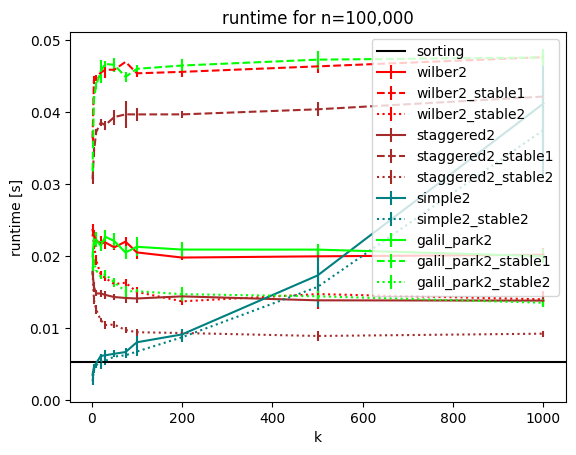

In [85]:
plot(df, 100_000, show_simple=True, ignores=("simple2_stable1",))

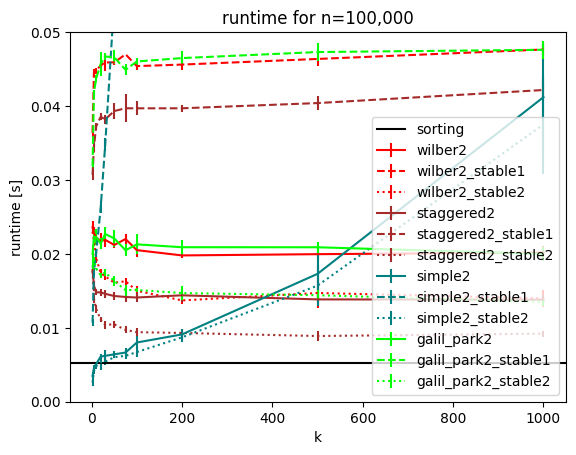

In [86]:
plot(df, 100_000, show_simple=True, max_y=0.05)

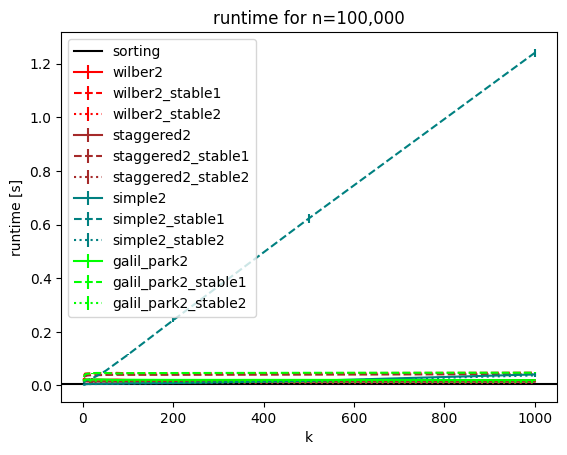

In [87]:
plot(df, 100_000, show_simple=False)

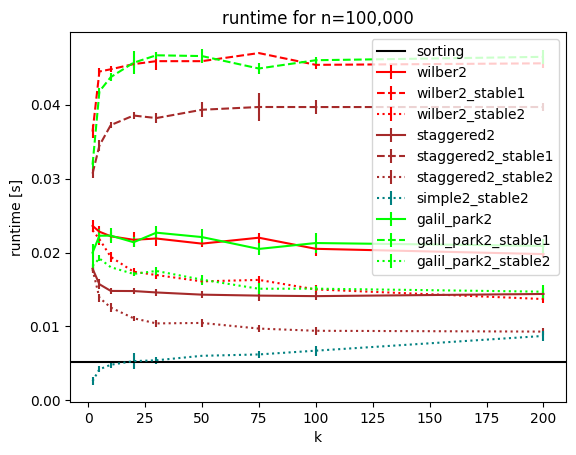

In [99]:
plot(df, 100_000, max_k=310, ignores=("simple2_stable1"))

In [97]:
%%time
large_methods = {
    "wilber2_stable2" : partial(_wilber2, stable=2),
    "galil_park2_stable2": partial(_galil_park2, stable=2),
    "staggered2_stable2": partial(_staggered2, stable=2),
    "simple2_stable2" : partial(_simple_dynamic_program2, stable=2),
#    "wilber_stable" : partial(wilber, stable=1),
#    "galil_park_stable": partial(_galil_park, stable=0),
}
records_large = execute([1_000_000], 10, large_methods, ks = [10,100,200,400,800, 1600, 2000, 3000, 4000, 5000])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1min 12s
Wall time: 1min 12s


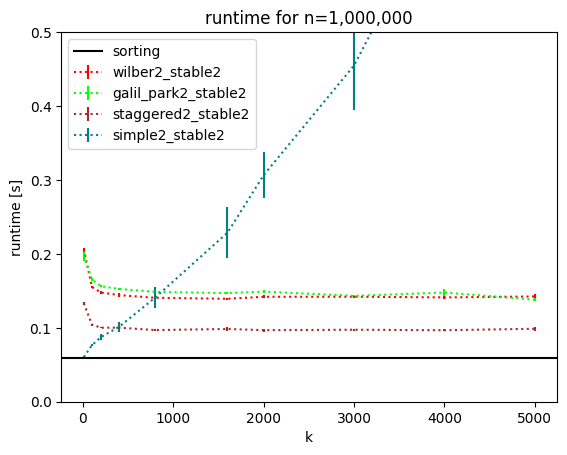

In [98]:
df_large = pd.DataFrame.from_records(records_large, columns=["name", "n", "k", "sample", "time"])
plot(df_large, 1_000_000, show_simple=True, max_y=0.5)